# Regime-Based Strategy Backtest

Test the hybrid regime strategy trading BTC, ETH, and LTC:
- **Individual direction**: Each coin long if above EMA50, short if below
- **Regime leverage**: Adjust portfolio leverage based on how many coins above EMA50

Compare with buy-and-hold benchmark.

## 1. Setup & Data Loading

In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("✓ Imports complete")

✓ Imports complete


In [16]:
from CoinTrading.data import DataLoader
from CoinTrading.indicators import EMA
from CoinTrading.strategy import RegimeBasedStrategy
from CoinTrading.backtesting import BacktestEngine, generate_report
from CoinTrading.backtesting.visualization import plot_comparison, plot_drawdown

# Load data for BTC, ETH, LTC
symbols = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT']

loader = DataLoader()
raw_data = loader.load_multiple(symbols, skip_errors=True)

processed_data = {}

for symbol in symbols:
    if symbol not in raw_data:
        print(f"Warning: {symbol} not loaded")
        continue
        
    df = raw_data[symbol].copy()
    
    # Calculate EMA50
    ema = EMA(period=50)
    df = ema.calculate(df)
    
    # Drop NaN rows
    df = df.dropna()
    
    processed_data[symbol] = df
    print(f"{symbol}: {len(df)} days from {df.index[0].date()} to {df.index[-1].date()}")

print(f"\n✓ Loaded {len(processed_data)} symbols")

INFO:CoinTrading.data.binance_client:Initialized BinanceClient for futures market
INFO:CoinTrading.data.data_loader:DataLoader initialized with cache: .cache/ohlcv
INFO:CoinTrading.data.data_loader:Successfully loaded 3/3 symbols


BTCUSDT: 480 days from 2024-06-13 to 2025-10-05
ETHUSDT: 480 days from 2024-06-13 to 2025-10-05
LTCUSDT: 480 days from 2024-06-13 to 2025-10-05

✓ Loaded 3 symbols


## 2. Strategy Configuration & Backtest

In [27]:
# Create regime-based strategy
strategy = RegimeBasedStrategy(
    symbols=['BTCUSDT', 'ETHUSDT', 'LTCUSDT'],
    ema_period=50,
    harsh_bull_leverage=2.0,  # All 3 above EMA50
    bull_leverage=0.,         # 2 of 3 above EMA50
    bear_leverage=0.,         # 1 of 3 above EMA50
    harsh_bear_leverage=2.0    # 0 of 3 above EMA50
)

print(f"Strategy: {strategy}")
print(f"\nRegime Leverage Settings:")
for regime, lev in strategy.regime_leverage.items():
    print(f"  {regime}: {lev}x")

INFO:CoinTrading.strategy.regime_based:Initialized RegimeBased(BTC/ETH/LTC): coins=['BTCUSDT', 'ETHUSDT', 'LTCUSDT'], ema_period=50, leverage={'harsh_bull': 2.0, 'bull': 0.0, 'bear': 0.0, 'harsh_bear': 2.0}


Strategy: RegimeBasedStrategy(symbols=['BTCUSDT', 'ETHUSDT', 'LTCUSDT'], ema_period=50, leverage={'harsh_bull': 2.0, 'bull': 0.0, 'bear': 0.0, 'harsh_bear': 2.0})

Regime Leverage Settings:
  harsh_bull: 2.0x
  bull: 0.0x
  bear: 0.0x
  harsh_bear: 2.0x


In [28]:
# Run backtest
engine = BacktestEngine(processed_data, transaction_fee=0.001)  # 0.1% fee
equity_curve = engine.run(strategy.get_weights)

_, returns, trade_log = engine.get_results()
report = generate_report(equity_curve, returns)

# Build position matrix from strategy weights
position_weights = {}
for date in equity_curve.index:
    weights = strategy.get_weights(date, processed_data)
    position_weights[date] = weights

positions = pd.DataFrame(position_weights).T.fillna(0)

print("\n" + "="*80)
print("Regime-Based Strategy Results")
print("="*80)
print(f"Backtest period: {equity_curve.index[0].date()} to {equity_curve.index[-1].date()}")
print(f"Total Return: {report.total_return:.1f}%")
print(f"CAGR: {report.cagr:.1f}%")
print(f"MDD: {report.mdd:.1f}%")
print(f"Sharpe: {report.sharpe:.2f}")
print(f"Win Rate: {report.win_rate:.1f}%")

INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 3 symbols, 480 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 0.4444 (-55.56%)



Regime-Based Strategy Results
Backtest period: 2024-06-14 to 2025-10-05
Total Return: -55.5%
CAGR: -46.0%
MDD: -69.9%
Sharpe: -0.21
Win Rate: 30.1%


## 3. Benchmark: Buy & Hold Equal Weight

In [29]:
# Create simple buy-and-hold benchmark
def buy_and_hold(date, data):
    """Equal weight buy and hold."""
    weights = {}
    for symbol in symbols:
        if symbol in data:
            weights[symbol] = 1.0 / len(symbols)
    return weights

# Run benchmark
engine_bh = BacktestEngine(processed_data, transaction_fee=0.001)
bh_equity = engine_bh.run(buy_and_hold)
_, bh_returns, _ = engine_bh.get_results()
bh_report = generate_report(bh_equity, bh_returns)

print("\n" + "="*80)
print("Buy & Hold Benchmark")
print("="*80)
print(f"Total Return: {bh_report.total_return:.1f}%")
print(f"CAGR: {bh_report.cagr:.1f}%")
print(f"MDD: {bh_report.mdd:.1f}%")
print(f"Sharpe: {bh_report.sharpe:.2f}")
print(f"Win Rate: {bh_report.win_rate:.1f}%")

INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 3 symbols, 480 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2024-06-13 to 2025-10-05
INFO:CoinTrading.backtesting.engine:Backtest complete. Final equity: 1.6675 (66.75%)



Buy & Hold Benchmark
Total Return: 66.9%
CAGR: 47.8%
MDD: -46.6%
Sharpe: 0.97
Win Rate: 54.4%


## 4. Performance Comparison

In [30]:
# Comparison table
print("\n" + "="*80)
print("Strategy vs Buy & Hold")
print("="*80)
print(f"{'Metric':<20} {'Regime Strategy':>18} {'Buy & Hold':>18} {'Difference':>18}")
print("-"*80)

metrics = [
    ('Total Return', report.total_return, bh_report.total_return, '%'),
    ('CAGR', report.cagr, bh_report.cagr, '%'),
    ('Max Drawdown', report.mdd, bh_report.mdd, '%'),
    ('Sharpe Ratio', report.sharpe, bh_report.sharpe, ''),
    ('Win Rate', report.win_rate, bh_report.win_rate, '%'),
]

for metric_name, strategy_val, bh_val, unit in metrics:
    diff = strategy_val - bh_val
    if unit == '%':
        print(f"{metric_name:<20} {strategy_val:>17.1f}{unit} {bh_val:>17.1f}{unit} {diff:>+17.1f}{unit}")
    else:
        print(f"{metric_name:<20} {strategy_val:>18.2f} {bh_val:>18.2f} {diff:>+18.2f}")

print("="*80)


Strategy vs Buy & Hold
Metric                  Regime Strategy         Buy & Hold         Difference
--------------------------------------------------------------------------------
Total Return                     -55.5%              66.9%            -122.4%
CAGR                             -46.0%              47.8%             -93.8%
Max Drawdown                     -69.9%             -46.6%             -23.3%
Sharpe Ratio                      -0.21               0.97              -1.18
Win Rate                          30.1%              54.4%             -24.3%


## 5. Equity Curve Visualization

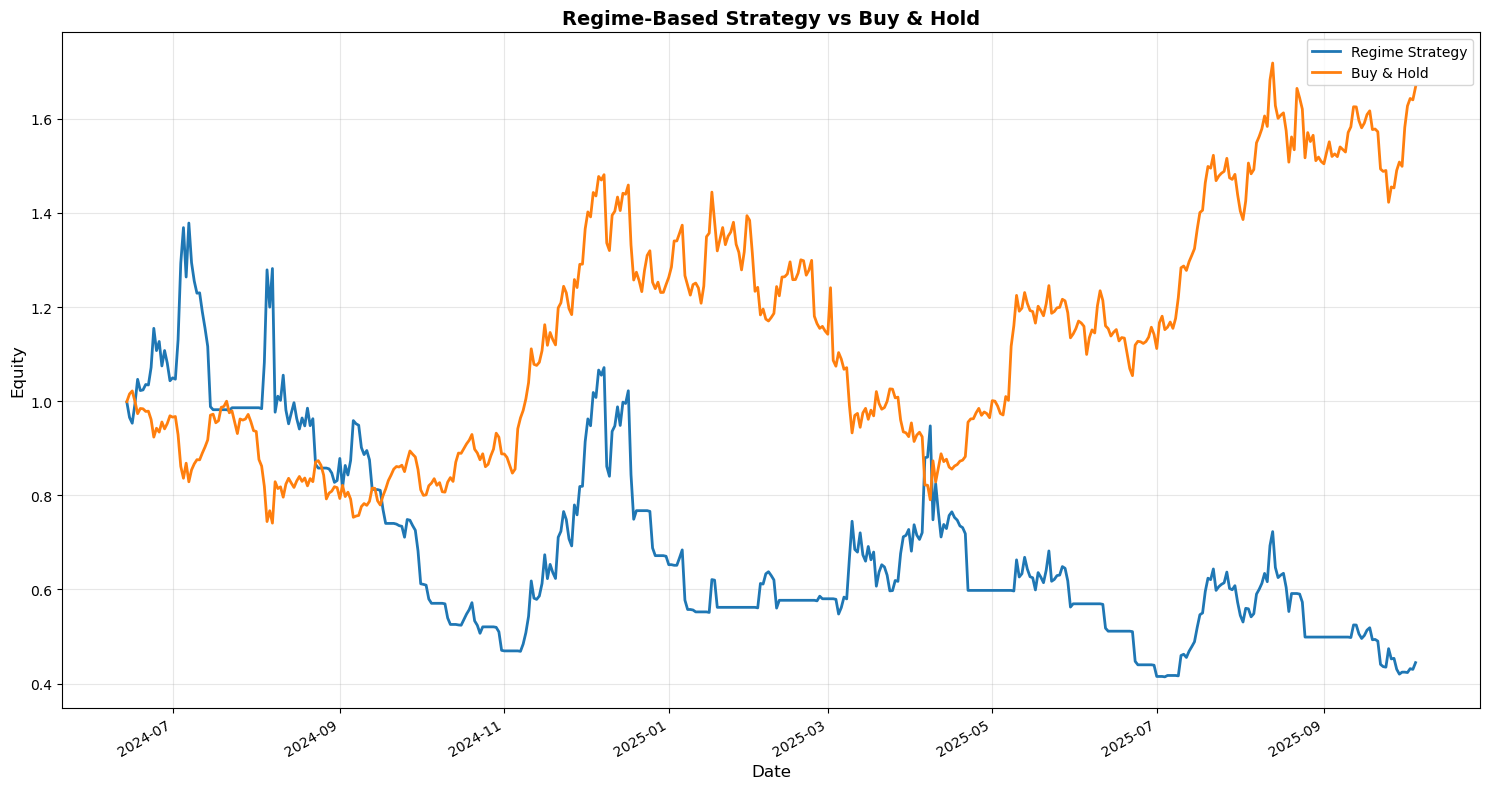


✓ Equity curve plotted


In [35]:
# Plot equity curves
fig = plot_comparison(
    {'Regime Strategy': equity_curve, 'Buy & Hold': bh_equity},
    title='Regime-Based Strategy vs Buy & Hold',
    log_scale=False,
    figsize=(15, 8)
)
plt.show()

print("\n✓ Equity curve plotted")

## 6. Position Analysis

In [32]:
# Analyze position history
print("\nSample Positions (last 20 days):")
print("="*80)
print(f"{'Date':<12} {'BTC':>10} {'ETH':>10} {'LTC':>10} {'Total Exposure':>15}")
print("-"*80)

# Show last 20 days
for idx in range(max(0, len(positions) - 20), len(positions)):
    date = positions.index[idx]
    row = positions.iloc[idx]
    btc_weight = row.get('BTCUSDT', 0)
    eth_weight = row.get('ETHUSDT', 0)
    ltc_weight = row.get('LTCUSDT', 0)
    total_exposure = abs(btc_weight) + abs(eth_weight) + abs(ltc_weight)
    
    print(f"{date.date()} {btc_weight:>+10.2f} {eth_weight:>+10.2f} {ltc_weight:>+10.2f} {total_exposure:>15.2f}")

print("="*80)

# Position statistics
print("\nPosition Statistics:")
print(f"  Average total exposure: {positions.abs().sum(axis=1).mean():.2f}")
print(f"  Max total exposure: {positions.abs().sum(axis=1).max():.2f}")
print(f"  Min total exposure: {positions.abs().sum(axis=1).min():.2f}")


Sample Positions (last 20 days):
Date                BTC        ETH        LTC  Total Exposure
--------------------------------------------------------------------------------
2025-09-16      +0.67      +0.67      +0.67            2.00
2025-09-17      +0.67      +0.67      +0.67            2.00
2025-09-18      +0.67      +0.67      +0.67            2.00
2025-09-19      +0.67      +0.67      +0.67            2.00
2025-09-20      +0.67      +0.67      +0.67            2.00
2025-09-21      +0.67      +0.67      +0.67            2.00
2025-09-22      -0.67      -0.67      -0.67            2.00
2025-09-23      -0.67      -0.67      -0.67            2.00
2025-09-24      -0.67      -0.67      -0.67            2.00
2025-09-25      -0.67      -0.67      -0.67            2.00
2025-09-26      -0.67      -0.67      -0.67            2.00
2025-09-27      -0.67      -0.67      -0.67            2.00
2025-09-28      -0.67      -0.67      -0.67            2.00
2025-09-29      +0.00      +0.00      -0.00

## 7. Regime-Specific Performance Analysis

Break down strategy performance by regime to identify which regimes contribute positively/negatively.


Strategy Performance by Regime
Regime              Days   Avg Return   Cum Return   Win Rate   Volatility
--------------------------------------------------------------------------------
harsh_bull           157        0.10%        -7.4%      46.5%        5.43%
bull                  94       -0.07%        -9.5%       9.6%        2.69%
bear                  82       -0.25%       -20.2%       3.7%        2.28%
harsh_bear           145       -0.10%       -33.4%      40.7%        6.06%


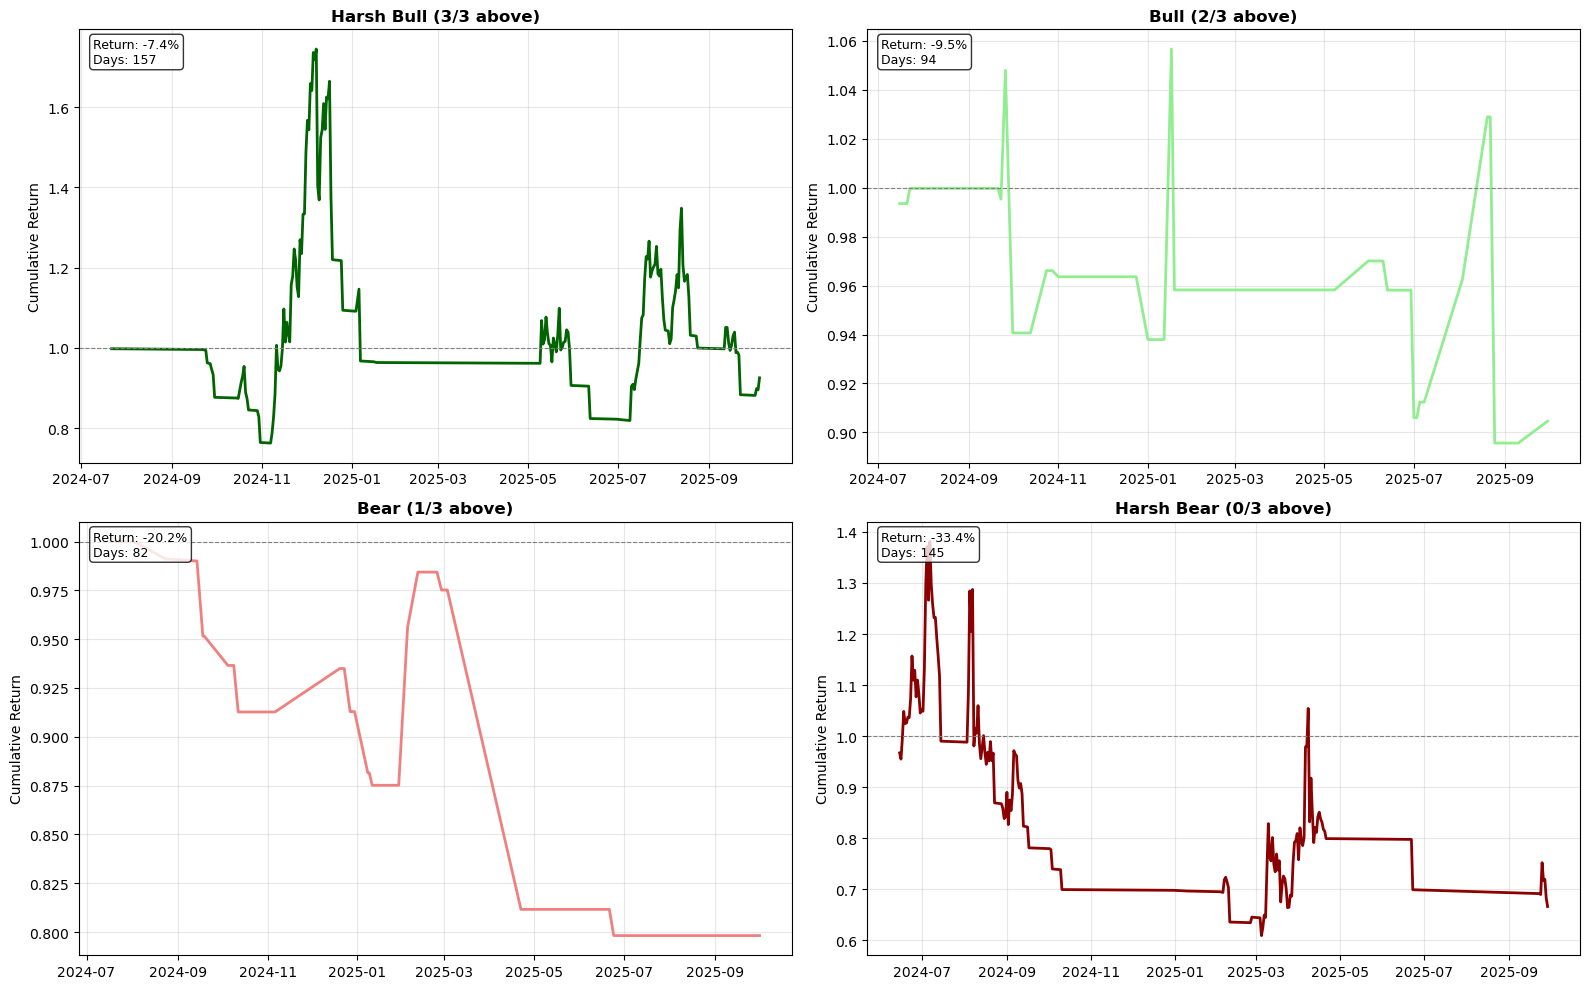


✓ Regime-specific performance analysis complete


In [33]:
# Detect regime for each date in backtest
regime_data = []

# Start from index 0 since equity_curve and returns are already aligned
for i in range(len(returns)):
    date = equity_curve.index[i + 1]  # equity_curve is 1 element longer
    yesterday = equity_curve.index[i]
    
    # Count coins above EMA50 yesterday
    above_count = 0
    for symbol in symbols:
        df = processed_data[symbol]
        if yesterday in df.index:
            close = df.loc[yesterday, 'close']
            ema50 = df.loc[yesterday, 'ema50']
            if close > ema50:
                above_count += 1
    
    # Classify regime
    if above_count == 3:
        regime = 'harsh_bull'
    elif above_count == 2:
        regime = 'bull'
    elif above_count == 1:
        regime = 'bear'
    else:
        regime = 'harsh_bear'
    
    # Get strategy return for this day
    strategy_return = returns.iloc[i]
    
    regime_data.append({
        'date': date,
        'regime': regime,
        'return': strategy_return
    })

regime_perf = pd.DataFrame(regime_data).set_index('date')

# Calculate performance by regime
print("\nStrategy Performance by Regime")
print("="*80)
print(f"{'Regime':<15} {'Days':>8} {'Avg Return':>12} {'Cum Return':>12} {'Win Rate':>10} {'Volatility':>12}")
print("-"*80)

for regime_name in ['harsh_bull', 'bull', 'bear', 'harsh_bear']:
    regime_mask = regime_perf['regime'] == regime_name
    if regime_mask.any():
        regime_returns = regime_perf[regime_mask]['return']
        days = len(regime_returns)
        avg_return = regime_returns.mean() * 100
        cum_return = ((1 + regime_returns).prod() - 1) * 100
        win_rate = (regime_returns > 0).sum() / len(regime_returns) * 100
        volatility = regime_returns.std() * 100
        
        print(f"{regime_name:<15} {days:>8} {avg_return:>11.2f}% {cum_return:>11.1f}% {win_rate:>9.1f}% {volatility:>11.2f}%")

print("="*80)

# Visualize regime performance
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

regime_names = ['harsh_bull', 'bull', 'bear', 'harsh_bear']
regime_labels = {
    'harsh_bull': 'Harsh Bull (3/3 above)',
    'bull': 'Bull (2/3 above)',
    'bear': 'Bear (1/3 above)',
    'harsh_bear': 'Harsh Bear (0/3 above)'
}
regime_colors_plot = {
    'harsh_bull': 'darkgreen',
    'bull': 'lightgreen',
    'bear': 'lightcoral',
    'harsh_bear': 'darkred'
}

for idx, regime_name in enumerate(regime_names):
    ax = axes[idx]
    regime_mask = regime_perf['regime'] == regime_name
    
    if regime_mask.any():
        regime_returns = regime_perf[regime_mask]['return']
        regime_equity = (1 + regime_returns).cumprod()
        
        ax.plot(regime_equity.index, regime_equity.values, 
                linewidth=2, color=regime_colors_plot[regime_name])
        ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8)
        ax.set_title(regime_labels[regime_name], fontsize=12, fontweight='bold')
        ax.set_ylabel('Cumulative Return', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add performance stats
        cum_return = ((1 + regime_returns).prod() - 1) * 100
        ax.text(0.02, 0.98, f'Return: {cum_return:+.1f}%\nDays: {len(regime_returns)}',
                transform=ax.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n✓ Regime-specific performance analysis complete")

## Summary

### Strategy Design:
- **Individual coin direction**: Long if above EMA50, short if below
- **Base weight**: 1/3 per coin (equal weight)
- **Regime leverage multipliers**:
  - Harsh Bull (3/3 above): 1.5x
  - Bull (2/3 above): 1.0x
  - Bear (1/3 above): 0.5x
  - Harsh Bear (0/3 above): 1.5x

### Key Features:
- Adaptive leverage based on market agreement
- Can be long, short, or mixed depending on individual coin positions
- Reduces exposure when coins disagree (Bear: 1/3 above)
- Increases exposure when coins agree (Harsh Bull/Bear: all same direction)

### Performance vs Buy & Hold:
See comparison table above for detailed metrics.

## 8. Position Turnover Analysis

Calculate how frequently positions change and estimate transaction cost impact.

## 9. Leverage Exposure Timeline

Visualize how leverage changes over time with regime backgrounds.

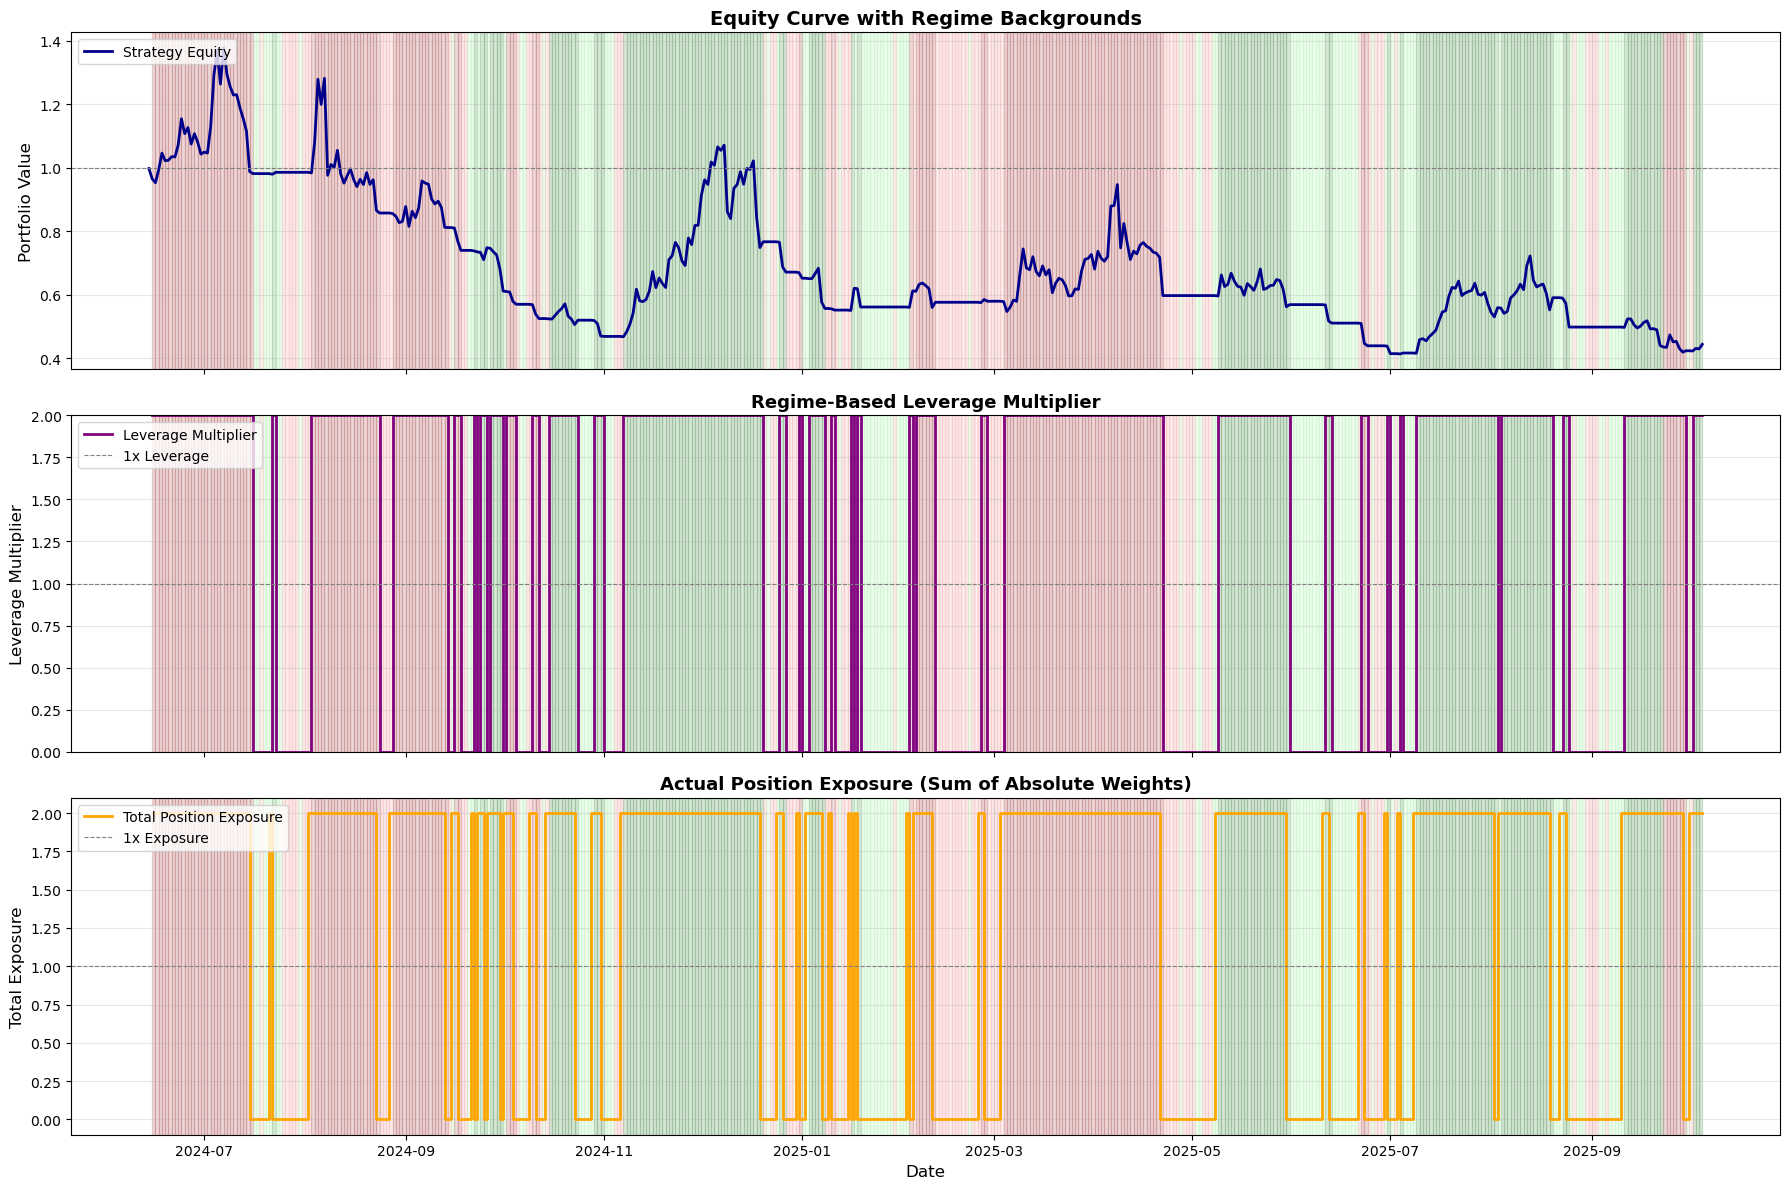


Leverage Statistics by Regime:
Regime              Days   Multiplier   Avg Exposure   Avg Return
--------------------------------------------------------------------------------
harsh_bull           157        2.00x           1.77        0.10%
bull                  94        0.00x           0.40       -0.07%
bear                  82        0.00x           0.32       -0.25%
harsh_bear           145        2.00x           1.81       -0.10%

Overall Exposure Statistics:
  Average exposure: 1.26
  Max exposure: 2.00
  Min exposure: 0.00
  Median exposure: 2.00

✓ Leverage exposure analysis complete


In [34]:
# Calculate effective leverage for each day
leverage_timeline = []

for i in range(1, len(equity_curve)):
    date = equity_curve.index[i]
    yesterday = equity_curve.index[i - 1]
    
    # Count coins above EMA50 yesterday
    above_count = 0
    for symbol in symbols:
        df = processed_data[symbol]
        if yesterday in df.index:
            close = df.loc[yesterday, 'close']
            ema50 = df.loc[yesterday, 'ema50']
            if close > ema50:
                above_count += 1
    
    # Classify regime and get leverage
    if above_count == 3:
        regime = 'harsh_bull'
        leverage = strategy.regime_leverage['harsh_bull']
    elif above_count == 2:
        regime = 'bull'
        leverage = strategy.regime_leverage['bull']
    elif above_count == 1:
        regime = 'bear'
        leverage = strategy.regime_leverage['bear']
    else:
        regime = 'harsh_bear'
        leverage = strategy.regime_leverage['harsh_bear']
    
    # Calculate actual position exposure
    if date in positions.index:
        total_exposure = positions.loc[date].abs().sum()
    else:
        total_exposure = 0
    
    leverage_timeline.append({
        'date': date,
        'regime': regime,
        'leverage_multiplier': leverage,
        'total_exposure': total_exposure
    })

leverage_df = pd.DataFrame(leverage_timeline).set_index('date')

# Regime colors
regime_colors = {
    'harsh_bull': 'darkgreen',
    'bull': 'lightgreen',
    'bear': 'lightcoral',
    'harsh_bear': 'darkred'
}

# Plot leverage and exposure over time
fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

# Plot 1: Equity curve
ax1 = axes[0]

# Color regime backgrounds
for i in range(len(leverage_df) - 1):
    date = leverage_df.index[i]
    next_date = leverage_df.index[i + 1]
    regime = leverage_df.loc[date, 'regime']
    color = regime_colors.get(regime, 'white')
    ax1.axvspan(date, next_date, alpha=0.15, color=color)

ax1.plot(equity_curve.index, equity_curve.values, linewidth=2, color='darkblue', label='Strategy Equity')
ax1.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8)
ax1.set_ylabel('Portfolio Value', fontsize=12)
ax1.set_title('Equity Curve with Regime Backgrounds', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Leverage multiplier
ax2 = axes[1]

for i in range(len(leverage_df) - 1):
    date = leverage_df.index[i]
    next_date = leverage_df.index[i + 1]
    regime = leverage_df.loc[date, 'regime']
    color = regime_colors.get(regime, 'white')
    ax2.axvspan(date, next_date, alpha=0.15, color=color)

ax2.plot(leverage_df.index, leverage_df['leverage_multiplier'], 
         linewidth=2, color='purple', label='Leverage Multiplier', drawstyle='steps-post')
ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8, label='1x Leverage')
ax2.set_ylabel('Leverage Multiplier', fontsize=12)
ax2.set_title('Regime-Based Leverage Multiplier', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 2])

# Plot 3: Total exposure
ax3 = axes[2]

for i in range(len(leverage_df) - 1):
    date = leverage_df.index[i]
    next_date = leverage_df.index[i + 1]
    regime = leverage_df.loc[date, 'regime']
    color = regime_colors.get(regime, 'white')
    ax3.axvspan(date, next_date, alpha=0.15, color=color)

ax3.plot(leverage_df.index, leverage_df['total_exposure'], 
         linewidth=2, color='orange', label='Total Position Exposure', drawstyle='steps-post')
ax3.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8, label='1x Exposure')
ax3.set_ylabel('Total Exposure', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_title('Actual Position Exposure (Sum of Absolute Weights)', fontsize=13, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nLeverage Statistics by Regime:")
print("="*80)
print(f"{'Regime':<15} {'Days':>8} {'Multiplier':>12} {'Avg Exposure':>14} {'Avg Return':>12}")
print("-"*80)

for regime_name in ['harsh_bull', 'bull', 'bear', 'harsh_bear']:
    regime_mask = leverage_df['regime'] == regime_name
    if regime_mask.any():
        days = regime_mask.sum()
        multiplier = leverage_df[regime_mask]['leverage_multiplier'].iloc[0]
        avg_exposure = leverage_df[regime_mask]['total_exposure'].mean()
        
        # Get returns for this regime
        regime_returns_mask = regime_perf['regime'] == regime_name
        if regime_returns_mask.any():
            avg_return = regime_perf[regime_returns_mask]['return'].mean() * 100
        else:
            avg_return = 0
        
        print(f"{regime_name:<15} {days:>8} {multiplier:>11.2f}x {avg_exposure:>14.2f} {avg_return:>11.2f}%")

print("="*80)
print("\nOverall Exposure Statistics:")
print(f"  Average exposure: {leverage_df['total_exposure'].mean():.2f}")
print(f"  Max exposure: {leverage_df['total_exposure'].max():.2f}")
print(f"  Min exposure: {leverage_df['total_exposure'].min():.2f}")
print(f"  Median exposure: {leverage_df['total_exposure'].median():.2f}")

print("\n✓ Leverage exposure analysis complete")

## 10. Individual Coin P&L Contribution

Break down returns by coin and position direction to identify which positions contributed positively/negatively.


Individual Coin P&L Contribution
Symbol       Position     Days      Avg P&L    Total P&L   Win Rate
--------------------------------------------------------------------------------

BTCUSDT:
                 long      295       0.213%       62.79%      57.6%
                short      183       0.175%       32.10%      57.4%

ETHUSDT:
                 long      215       0.522%      112.18%      60.9%
                short      263       0.280%       73.75%      57.4%

LTCUSDT:
                 long      234       0.452%      105.77%      59.4%
                short      244       0.246%       59.94%      52.9%

Overall Coin Contribution:
BTCUSDT    Total P&L:      +94.89%
ETHUSDT    Total P&L:     +185.93%
LTCUSDT    Total P&L:     +165.71%
--------------------------------------------------------------------------------
TOTAL                      +446.53%
Actual Return                  -43.37%


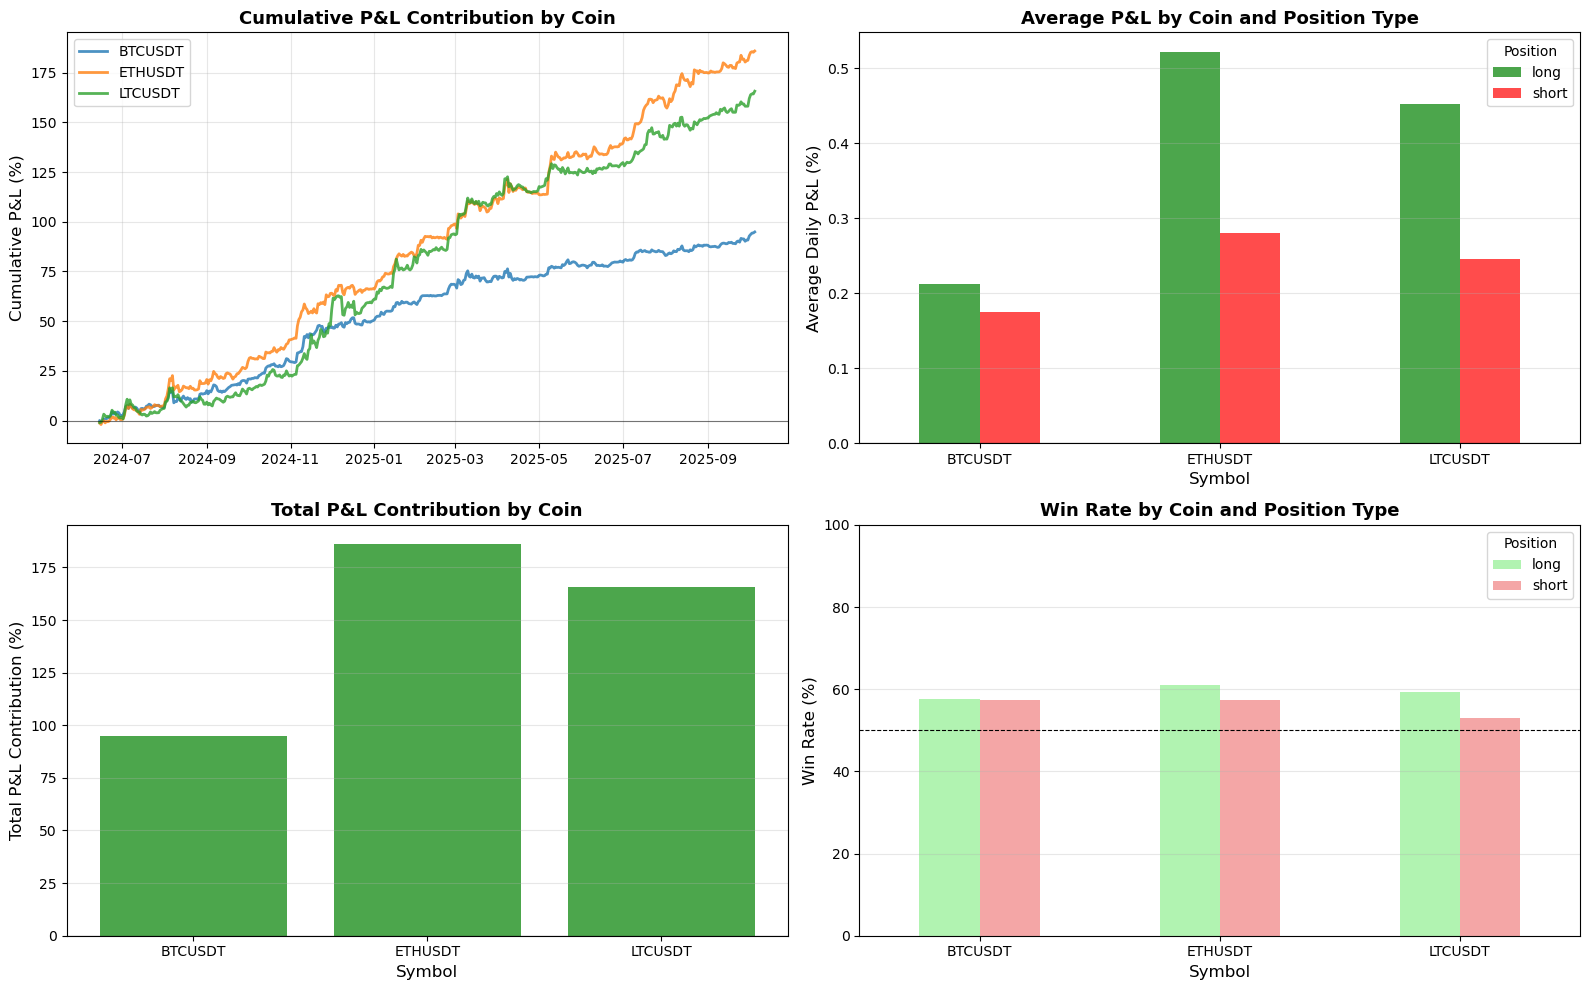


✓ Individual coin P&L analysis complete


In [11]:
# Calculate individual coin P&L contributions
coin_pnl = []

for i in range(1, len(equity_curve)):
    date = equity_curve.index[i]
    prev_date = equity_curve.index[i - 1]
    
    if date not in positions.index:
        continue
    
    for symbol in symbols:
        if symbol in positions.columns:
            position_weight = positions.loc[date, symbol]
            
            if position_weight != 0 and symbol in processed_data:
                df = processed_data[symbol]
                
                if date in df.index and prev_date in df.index:
                    # Calculate return from previous close to current close
                    asset_return = df.loc[date, 'close'] / df.loc[prev_date, 'close'] - 1
                    
                    # P&L contribution
                    pnl_contribution = position_weight * asset_return
                    
                    # Determine position type
                    position_type = 'long' if position_weight > 0 else 'short'
                    
                    coin_pnl.append({
                        'date': date,
                        'symbol': symbol,
                        'position_weight': position_weight,
                        'position_type': position_type,
                        'asset_return': asset_return * 100,
                        'pnl_contribution': pnl_contribution * 100
                    })

coin_pnl_df = pd.DataFrame(coin_pnl)

# Summary by coin and position type
print("\nIndividual Coin P&L Contribution")
print("="*80)
print(f"{'Symbol':<10} {'Position':>10} {'Days':>8} {'Avg P&L':>12} {'Total P&L':>12} {'Win Rate':>10}")
print("-"*80)

for symbol in symbols:
    symbol_data = coin_pnl_df[coin_pnl_df['symbol'] == symbol]
    
    if not symbol_data.empty:
        print(f"\n{symbol}:")
        
        for position_type in ['long', 'short']:
            pos_data = symbol_data[symbol_data['position_type'] == position_type]
            
            if not pos_data.empty:
                days = len(pos_data)
                avg_pnl = pos_data['pnl_contribution'].mean()
                total_pnl = pos_data['pnl_contribution'].sum()
                win_rate = (pos_data['pnl_contribution'] > 0).sum() / len(pos_data) * 100
                
                print(f"{'':10} {position_type:>10} {days:>8} {avg_pnl:>11.3f}% {total_pnl:>11.2f}% {win_rate:>9.1f}%")

print("="*80)

# Overall summary
print("\nOverall Coin Contribution:")
print("="*80)

for symbol in symbols:
    symbol_data = coin_pnl_df[coin_pnl_df['symbol'] == symbol]
    if not symbol_data.empty:
        total_pnl = symbol_data['pnl_contribution'].sum()
        print(f"{symbol:<10} Total P&L: {total_pnl:>+11.2f}%")

total_pnl_all = coin_pnl_df['pnl_contribution'].sum()
print("-"*80)
print(f"{'TOTAL':<10} {'':>11} {total_pnl_all:>+11.2f}%")
print(f"{'Actual Return':<10} {'':>11} {report.total_return:>+11.2f}%")
print("="*80)

# Visualize coin contributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Cumulative P&L by coin
ax1 = axes[0, 0]
for symbol in symbols:
    symbol_data = coin_pnl_df[coin_pnl_df['symbol'] == symbol].set_index('date')
    if not symbol_data.empty:
        cum_pnl = symbol_data['pnl_contribution'].cumsum()
        ax1.plot(cum_pnl.index, cum_pnl.values, linewidth=2, label=symbol, alpha=0.8)

ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax1.set_ylabel('Cumulative P&L (%)', fontsize=12)
ax1.set_title('Cumulative P&L Contribution by Coin', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Average P&L by coin and position
ax2 = axes[0, 1]
summary_data = []
for symbol in symbols:
    for position_type in ['long', 'short']:
        pos_data = coin_pnl_df[(coin_pnl_df['symbol'] == symbol) & 
                                (coin_pnl_df['position_type'] == position_type)]
        if not pos_data.empty:
            summary_data.append({
                'symbol': symbol,
                'position': position_type,
                'avg_pnl': pos_data['pnl_contribution'].mean()
            })

summary_df = pd.DataFrame(summary_data)
if not summary_df.empty:
    pivot_data = summary_df.pivot(index='symbol', columns='position', values='avg_pnl')
    pivot_data.plot(kind='bar', ax=ax2, color=['green', 'red'], alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax2.set_ylabel('Average Daily P&L (%)', fontsize=12)
    ax2.set_title('Average P&L by Coin and Position Type', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Symbol', fontsize=12)
    ax2.legend(title='Position')
    ax2.grid(True, alpha=0.3, axis='y')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

# Plot 3: Total P&L by coin
ax3 = axes[1, 0]
coin_totals = []
for symbol in symbols:
    symbol_data = coin_pnl_df[coin_pnl_df['symbol'] == symbol]
    if not symbol_data.empty:
        coin_totals.append({
            'symbol': symbol,
            'total_pnl': symbol_data['pnl_contribution'].sum()
        })

coin_totals_df = pd.DataFrame(coin_totals)
if not coin_totals_df.empty:
    colors = ['green' if x > 0 else 'red' for x in coin_totals_df['total_pnl']]
    ax3.bar(coin_totals_df['symbol'], coin_totals_df['total_pnl'], color=colors, alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax3.set_ylabel('Total P&L Contribution (%)', fontsize=12)
    ax3.set_title('Total P&L Contribution by Coin', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Symbol', fontsize=12)
    ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Win rate by coin and position
ax4 = axes[1, 1]
winrate_data = []
for symbol in symbols:
    for position_type in ['long', 'short']:
        pos_data = coin_pnl_df[(coin_pnl_df['symbol'] == symbol) & 
                                (coin_pnl_df['position_type'] == position_type)]
        if not pos_data.empty:
            win_rate = (pos_data['pnl_contribution'] > 0).sum() / len(pos_data) * 100
            winrate_data.append({
                'symbol': symbol,
                'position': position_type,
                'win_rate': win_rate
            })

winrate_df = pd.DataFrame(winrate_data)
if not winrate_df.empty:
    pivot_winrate = winrate_df.pivot(index='symbol', columns='position', values='win_rate')
    pivot_winrate.plot(kind='bar', ax=ax4, color=['lightgreen', 'lightcoral'], alpha=0.7)
    ax4.axhline(y=50, color='black', linestyle='--', linewidth=0.8)
    ax4.set_ylabel('Win Rate (%)', fontsize=12)
    ax4.set_title('Win Rate by Coin and Position Type', fontsize=13, fontweight='bold')
    ax4.set_xlabel('Symbol', fontsize=12)
    ax4.legend(title='Position')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim([0, 100])
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n✓ Individual coin P&L analysis complete")


Position Turnover Analysis
Total Days: 479
Days with Position Changes: 104 (21.7%)
Total Turnover: 121.00
Average Daily Turnover: 0.2526
Max Daily Turnover: 3.00

Transaction Cost Estimate (fee rate: 0.1%):
  Total fees paid: 0.1210 (12.10% of initial capital)
  Average daily fee: 0.000253

Performance Impact:
  Actual strategy return: -43.4%
  Estimated fees: 12.10%
  Hypothetical return without fees: -31.3%


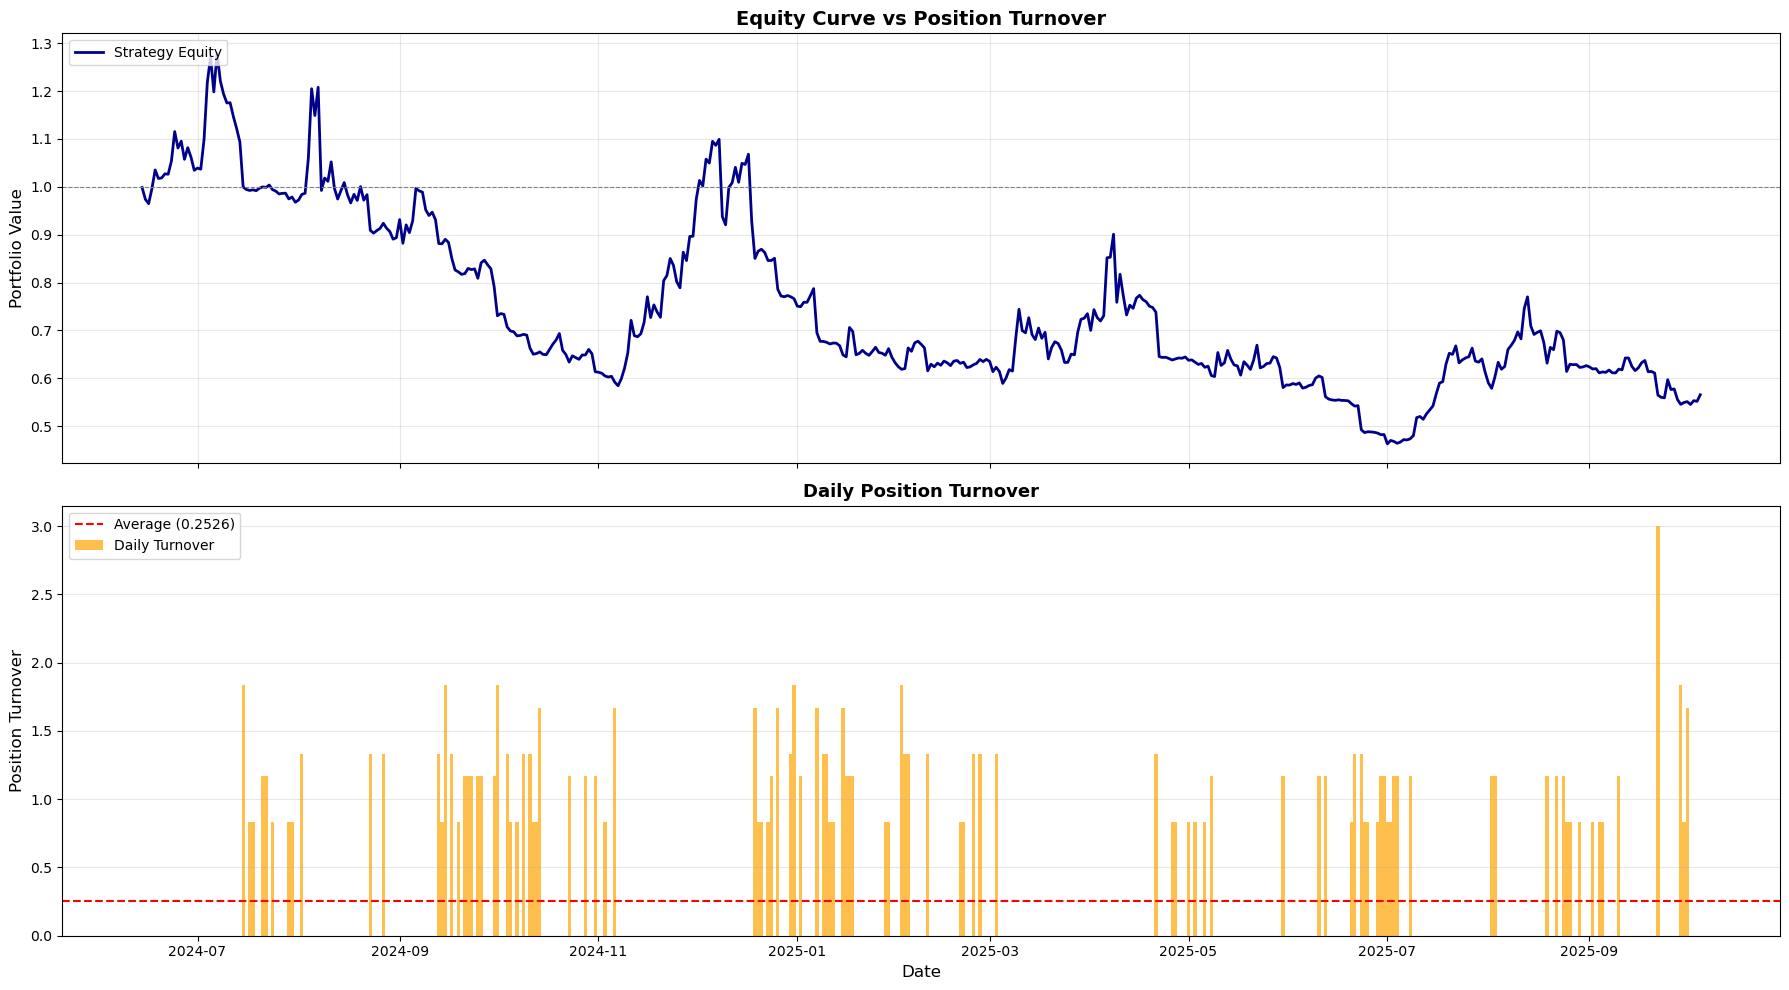


Position Change Frequency by Coin:
Symbol        Changes    Frequency   Avg Change
--------------------------------------------------------------------------------
BTCUSDT           104        21.7%       0.3526
ETHUSDT           104        21.7%       0.3878
LTCUSDT           104        21.7%       0.4231

✓ Turnover analysis complete


In [12]:
# Calculate position changes and turnover
position_changes = positions.diff().abs()
turnover = position_changes.sum(axis=1)  # Total position change per day

# Calculate turnover statistics
total_turnover = turnover.sum()
avg_daily_turnover = turnover.mean()
max_daily_turnover = turnover.max()
days_with_changes = (turnover > 0).sum()
change_frequency = days_with_changes / len(turnover) * 100

print("\nPosition Turnover Analysis")
print("="*80)
print(f"Total Days: {len(turnover)}")
print(f"Days with Position Changes: {days_with_changes} ({change_frequency:.1f}%)")
print(f"Total Turnover: {total_turnover:.2f}")
print(f"Average Daily Turnover: {avg_daily_turnover:.4f}")
print(f"Max Daily Turnover: {max_daily_turnover:.2f}")
print("="*80)

# Estimate transaction cost impact
fee_rate = 0.001  # 0.1% per trade
estimated_total_fees = total_turnover * fee_rate
estimated_fee_impact = estimated_total_fees * 100  # As percentage points

print(f"\nTransaction Cost Estimate (fee rate: {fee_rate*100}%):")
print(f"  Total fees paid: {estimated_total_fees:.4f} ({estimated_fee_impact:.2f}% of initial capital)")
print(f"  Average daily fee: {estimated_total_fees / len(turnover):.6f}")

# Compare with actual performance
print(f"\nPerformance Impact:")
print(f"  Actual strategy return: {report.total_return:.1f}%")
print(f"  Estimated fees: {estimated_fee_impact:.2f}%")
print(f"  Hypothetical return without fees: {report.total_return + estimated_fee_impact:.1f}%")
print("="*80)

# Visualize turnover over time
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Plot 1: Equity curve
ax1 = axes[0]
ax1.plot(equity_curve.index, equity_curve.values, linewidth=2, color='darkblue', label='Strategy Equity')
ax1.axhline(y=1.0, color='gray', linestyle='--', linewidth=0.8)
ax1.set_ylabel('Portfolio Value', fontsize=12)
ax1.set_title('Equity Curve vs Position Turnover', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Turnover
ax2 = axes[1]
ax2.bar(turnover.index, turnover.values, width=1, color='orange', alpha=0.7, label='Daily Turnover')
ax2.axhline(y=avg_daily_turnover, color='red', linestyle='--', linewidth=1.5, 
            label=f'Average ({avg_daily_turnover:.4f})')
ax2.set_ylabel('Position Turnover', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_title('Daily Position Turnover', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Position change breakdown by coin
print("\nPosition Change Frequency by Coin:")
print("="*80)
print(f"{'Symbol':<10} {'Changes':>10} {'Frequency':>12} {'Avg Change':>12}")
print("-"*80)

for symbol in symbols:
    if symbol in position_changes.columns:
        coin_changes = position_changes[symbol]
        changes_count = (coin_changes > 0).sum()
        frequency = changes_count / len(coin_changes) * 100
        avg_change = coin_changes[coin_changes > 0].mean() if (coin_changes > 0).any() else 0
        
        print(f"{symbol:<10} {changes_count:>10} {frequency:>11.1f}% {avg_change:>12.4f}")

print("="*80)
print("\n✓ Turnover analysis complete")